In [1]:
import torch
import gensim
import implicit
import numpy as np
import pandas as pd
import scipy.sparse as sp
from tqdm import tqdm_notebook
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

# Paths

In [30]:
FOLDER_PATH = "./"

# Load data

In [2]:
df = pd.read_csv(f"{FOLDER_PATH}ratings.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


# Preprocessing data

In [3]:
tmp = np.sum(df.userId.value_counts() < 20) / len(df) * 100
print(f"Number of users who rated less than 20 movies: {tmp:.2f}%")

Number of users who rated less than 20 movies: 0.00%


In [4]:
tmp = np.sum(df.movieId.value_counts() < 20) / len(df) * 100
print(f"Number of movies rated by less than 20 users: {tmp:.2f}%")

Number of movies rated by less than 20 users: 0.07%


In [5]:
movies_to_remove = set(np.unique(df.movieId)[(df.movieId.value_counts() < 20).sort_index()])
df.movieId = df.movieId.apply(lambda x: np.nan if x in movies_to_remove else x)
df.dropna(inplace=True)
df.movieId = df.movieId.astype(int)

tmp = np.sum(df.movieId.value_counts() < 20) / len(df) * 100
print(f"Number of movies rated by less than 20 users: {tmp:.2f}%")

Number of movies rated by less than 20 users: 0.00%


In [6]:
tmp = np.sum(df.groupby(by=["userId", "rating"]).count()["movieId"] < 2) / len(df)
print(f"Number of ratings using each user only once: {tmp:.2f}%")

Number of ratings using each user only once: 0.01%


In [7]:
dist = df.groupby(by=["userId", "rating"]).count()["movieId"]
df.set_index(keys=["userId","rating"], inplace=True)
df.drop(dist.index[dist < 2], inplace=True)
df.reset_index(inplace=True)

tmp = np.sum(df.groupby(by=["userId", "rating"]).count()["movieId"] < 2) / len(df)
print(f"Number of ratings using each user only once: {tmp:.2f}%")

Number of ratings using each user only once: 0.00%


In [8]:
train, val = train_test_split(df, test_size=0.2, random_state=42, stratify=df[["userId","rating"]])

# Train ImplicitALS

In [9]:
def ndcg_k(relevance, k=10):
    denominator = np.log2(np.arange(2, k + 2))  
    return np.sum(relevance[:k] / denominator) / np.sum(1 / denominator)

In [10]:
df = df.sort_values("rating", ascending=False)

In [11]:
movie_user_data = sp.csr_matrix((train.values[:,1], (train.values[:,2].astype(int),
                                                     train.values[:,0].astype(int))))

In [29]:
als_model = implicit.als.AlternatingLeastSquares(factors=128, calculate_training_loss=True)

In [13]:
als_model.fit(movie_user_data, show_progress=True)

In [14]:
N_USERS = 1000
ndcg_1, ndcg_10 = [], []
movie_items = movie_user_data.T

for user in tqdm_notebook(df.userId.unique()[:N_USERS]):
    relevance = []
    pred_recommendations = als_model.recommend(user, movie_items, N=10)
    ratings = df[df.userId == user][:10].rating.unique()
    for rating in ratings:
        equal_movies = df[(df.userId == user) & (df.rating == rating)].movieId.values
        for _ in enumerate(equal_movies):
            if pred_recommendations[len(relevance)][0] in equal_movies:
                relevance.append(1)
            else:
                relevance.append(0)
            if len(relevance) == 10:
                break
    ndcg_1.append(ndcg_k(relevance, 1))
    ndcg_10.append(ndcg_k(relevance, 10))

In [15]:
print(f"NDCG@1 = {np.mean(ndcg_1):.2f}, NDCG@10 = {np.mean(ndcg_10):.2f} calculated on {N_USERS} users")

NDCG@1 = 0.38, NDCG@10 = 0.36 calculated on 1000 users


# Word2Vec

In [16]:
w2v_train = train.sort_values(by=["userId","timestamp"]).reset_index(drop=True)
w2v_train.movieId = w2v_train.movieId.astype('str')
sequences = [w2v_train[w2v_train.userId == userid].movieId.tolist()
             for userid in tqdm_notebook(w2v_train.userId.unique())]

In [17]:
word2vec = gensim.models.Word2Vec(sequences, size=128, window=5)

In [18]:
NUMBER_NEIGHBORS = 5
n_movies = df.movieId.max()
movieIds = np.unique(df.movieId)
topk_cosines = np.zeros((n_movies + 1, NUMBER_NEIGHBORS))
topk_movieIds = np.zeros((n_movies + 1, NUMBER_NEIGHBORS))
for movieId in movieIds:
    for idx, movieId_cos in enumerate(word2vec.wv.most_similar(str(movieId), topn=NUMBER_NEIGHBORS)):
        topk_cosines[movieId, idx] = movieId_cos[1]
        topk_movieIds[movieId, idx] = int(movieId_cos[0])    

# Model

In [19]:
class UserMovieDataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return (torch.LongTensor([self.df.userId.iloc[idx]]),
                torch.LongTensor([self.df.movieId.iloc[idx]]),
                torch.FloatTensor([self.df.rating.iloc[idx]]))

class SuperDuperMF(torch.nn.Module):
    
    def __init__(self, n_users, n_movies, n_factors=128, w2v_topk_cos=topk_cosines, w2v_topk_ids=topk_movieIds):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
        self.movie_factors = torch.nn.Embedding(n_movies, n_factors, sparse=True)
        
        self.user_biases = torch.nn.Embedding(n_users, 1, sparse=True)
        self.movie_biases = torch.nn.Embedding(n_movies, 1, sparse=True)
        
        self.topk_w2v_cos = torch.nn.Embedding.from_pretrained(torch.Tensor(w2v_topk_cos), sparse=True)
        self.topk_w2v_cos.requires_grad = False
        
        self.topk_w2v_ids = torch.nn.Embedding.from_pretrained(torch.Tensor(w2v_topk_ids), sparse=True)
        self.topk_w2v_ids.requires_grad = False
        
    def forward(self, users, movies):
        pred_ratings = self.user_biases(users) + self.movie_biases(movies)
        pred_ratings += (self.user_factors(users) * self.movie_factors(movies)).sum(dim=-1, keepdim=True)
        topk_sim = self.topk_w2v_cos(movies).squeeze(dim=1)
        topk_pred_sim = torch.cosine_similarity(self.movie_factors(self.topk_w2v_ids(movies).long()).squeeze(dim=1),
                                                self.movie_factors(movies), dim=-1)
        return pred_ratings.squeeze(dim=-1), topk_sim, topk_pred_sim
    
    def predict_rating(self, users, movies):        
        return self.forward(users, movies)[0]
    
    def recommend_k_movies(self, users, k=1):
        return torch.topk((model.user_factors(users) + model.user_biases(users)).squeeze() @ 
                          (model.movie_factors.weight.T + model.movie_factors.weight.T), k=k)[1]
        

In [20]:
N_FACTORS = 128
BATCH_SIZE = 1024
n_users = df.userId.max()
n_movies = df.movieId.max()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data = UserMovieDataset(train)
val_data = UserMovieDataset(val)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
model = SuperDuperMF(n_users + 1, n_movies + 1, n_factors=N_FACTORS).to(device)

In [22]:
ALPHA = 0.5
NUM_EPOCHS = 60
INITIAL_LR = 1e-3
train_loss, val_loss = [], []
best_loss, counter = np.inf, 0

criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.SparseAdam(filter(lambda p: p.requires_grad, model.parameters()), lr=INITIAL_LR)

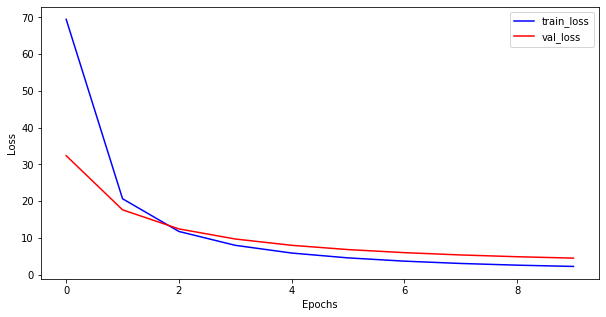

Epoch = 10
Train loss = 2.233	Val loss = 4.496
Manual Interruption
CPU times: user 4h 47min 7s, sys: 3min 6s, total: 4h 50min 13s
Wall time: 4h 49min 18s


In [23]:
%%time

try:
    for epoch in range(NUM_EPOCHS):
        counter += 1
        model.train()
        epoch_train_loss = []
        for users, movies, ratings in train_loader:
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
            pred_ratings, topk_sim, topk_pred_sim = model(users, movies)                   
            loss = criterion(pred_ratings, ratings) + ALPHA * criterion(topk_sim, topk_pred_sim)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()            
            epoch_train_loss.append(loss.item())
        train_loss.append(np.mean(epoch_train_loss))
        
        model.eval()
        epoch_val_loss = []
        with torch.no_grad():
            for users, movies, ratings in val_loader:
                users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
                pred_ratings, topk_sim, topk_pred_sim = model(users, movies)
                loss = criterion(pred_ratings, ratings) + ALPHA * criterion(topk_sim, topk_pred_sim)
                epoch_val_loss.append(loss.item())
            val_loss.append(np.mean(epoch_val_loss))
        
        if val_loss[-1] < best_loss:
            best_loss = val_loss[-1]
            torch.save(model.state_dict(), "best_model.pth")
            counter = 0
            
        if counter == 5:
            print(f"***Early stop happened on {len(train_loss)} epoch.***")
            break
        
        clear_output(True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_loss, label='train_loss', c='b')
        plt.plot(val_loss, label='val_loss', c='r')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        
        print(f"Epoch = {len(train_loss)}")
        print(f"Train loss = {train_loss[-1]:.3f}\tVal loss = {val_loss[-1]:.3f}")
        
    print("Training successfully finished!")

except KeyboardInterrupt:
    print("Manual Interruption")

In [27]:
N_USERS = 1000
ndcg_1, ndcg_10 = [], []
for user in tqdm_notebook(df.userId.unique()[:N_USERS]):
    relevance = []
    pred_recommendations = model.recommend_k_movies(torch.LongTensor([user]).cuda(), k=10).cpu().numpy()
    ratings = df[df.userId == user][:10].rating.unique()
    for rating in ratings:
        equal_movies = df[(df.userId == user) & (df.rating == rating)].movieId.values
        for _ in enumerate(equal_movies):
            if pred_recommendations[len(relevance)] in equal_movies:
                relevance.append(1)
            else:
                relevance.append(0)
            if len(relevance) == 10:
                break
    ndcg_1.append(ndcg_k(relevance, 1))
    ndcg_10.append(ndcg_k(relevance, 10))

In [28]:
print(f"NDCG@1 = {np.mean(ndcg_1):.2f}, NDCG@10 = {np.mean(ndcg_10):.2f} calculated on {N_USERS} users")

NDCG@1 = 0.00, NDCG@10 = 0.00 calculated on 1000 users
